# Predicción del cancer de mama

Por: [Leonardo Genzano](https://www.linkedin.com/in/leonardo-genzano-1b275193/)

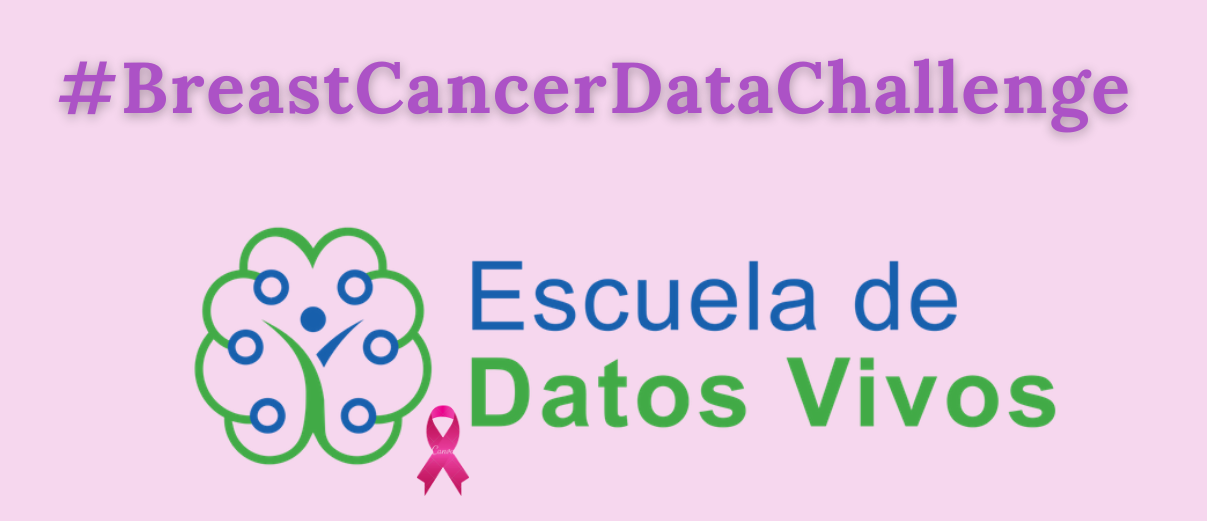

**El objetivo es predecir a partir de las características de un tumor, si una persona tiene cáncer o no.**

Este notebook se realiza aplicando los conocimientos aprendidos en el curso "Ciencia de datos 360 en Python" de la Escuela de Datos Vivos<br>
https://escueladedatosvivos.ai/courses<br>

Nota: esta es una version preliminar. En cuanto disponga de más tiempo, continuo con el análisis y el modelado.<br>
En algunos casos, oculte el codigo para que no se haga denso el post. Para verlo, presiona el botón Code que esta arriba a la derecha de cada visualización. 


# Contexto

Datos de Argentina:<br>
* El cáncer de mama es la primera causa de muerte por tumores en mujeres, provocando 5400 muertes por año <br>
* Más del 75% de las mujeres con cáncer de mama no tienen ningún antecedente familiar de dicha enfermedad.<br>
* Para el cáncer de mama la detección temprana es fundamental, ya que los tumores de menos de 1 centímetro tienen hasta el 90% de probabilidades de curación.<br>
* El cáncer de mama se puede producir tanto en hombres como en mujeres; sin embargo, es mucho más común en las mujeres.<br>

Fuente: Ministerio de Salud de Argentina

********************

Cargamos las librerias que vamos a utilizar

In [1]:
pip install funpymodeling

     |████████████████████████████████| 11.6 MB 3.6 MB/s 
     |████████████████████████████████| 215 kB 64.7 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.1
    Uninstalling matplotlib-3.2.1:
      Successfully uninstalled matplotlib-3.2.1
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 2.8 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.2
    Uninstalling matplotlib-3.3.2:
      Successfully uninstalled matplotlib-3.3.2
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

pandas-profiling 2.6.0 requires matplotlib>=3.2.0, but you'll have matplotlib 3.1.3 which is incompatible.
osmnx 0.15.1 requires matplotlib>=3.2, but you'll have matplotlib 3.1.3 which is incompatible.
funpymodeling 0.1.7 requires matplotlib<4.0.0,>=3.2.2, but you'll have matplotlib 3.1.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas_profiling import ProfileReport
from funpymodeling.exploratory import freq_tbl, status, profiling_num, cat_vars, num_vars, corr_pair
from sklearn.metrics import confusion_matrix

In [4]:
data = pd.read_csv("../input/breastcancerwisconsindata/breast-cancer-wisconsin.data", delimiter=",")

Renombramos columnas según lo que indica el archivo de names

In [5]:
data = data.rename(columns={"1000025": "Sample code number", 
                             "5": "Clump Thickness", 
                             '1' : 'Uniformity of Cell Size',
                             '1.1':'Uniformity of Cell Shape',
                             '1.2':'Marginal Adhesion',
                             '2': 'Single Epithelial Cell Size',
                             '1.3': 'Bare Nuclei',
                             '3': 'Bland Chromatin',
                             '1.4': 'Normal Nucleoli',
                             '1.5': 'Mitoses',
                             '2.1': 'Class'})

# Analisis Inicial

Cantidad de registros:

In [6]:
len(data)

698

In [7]:
status(data)

variable  q_nan  p_nan  q_zeros  p_zeros  unique  \
0            Sample code number      0    0.0        0      0.0     644   
1               Clump Thickness      0    0.0        0      0.0      10   
2       Uniformity of Cell Size      0    0.0        0      0.0      10   
3      Uniformity of Cell Shape      0    0.0        0      0.0      10   
4             Marginal Adhesion      0    0.0        0      0.0      10   
5   Single Epithelial Cell Size      0    0.0        0      0.0      10   
6                   Bare Nuclei      0    0.0        0      0.0      11   
7               Bland Chromatin      0    0.0        0      0.0      10   
8               Normal Nucleoli      0    0.0        0      0.0      10   
9                       Mitoses      0    0.0        0      0.0       9   
10                        Class      0    0.0        0      0.0       2   

      type  
0    int64  
1    int64  
2    int64  
3    int64  
4    int64  
5    int64  
6   object  
7    int64  
8    int64  
9    int64  
10   int64

* Según la documentación, todas las variables van de 1 a 10 (menos el ID y Class)<br>
* Sample Code Number es el ID. Tiene 644 registros unicos, sin embargo el dataset tiene 698 registros en total. Es decir, algunas personas aparecen más de una vez.
* **Bare Nuclei** vemos que tiene 11 registros unicos, y ademas es tipo object. En este caso hay que arreglar algo<br>
* Mitoses trae 9 registros unicos. Aca no necesariamente es algo incorrecto

**Clase a predecir**<br>
<br>
Cuando dice 2 significa que el tumor es benigno (no tiene cáncer). En cambio cuando dice 4, significa maligno ( si tiene cáncer).<br>
Le asignamos 0 y 1 a la clase. 0 = benigno 1 = maligno<br>
Esto lo hacemos para posteriormente entrenar correctamente el modelo 

In [8]:
data_map = {2: 0, 4: 1}
data['Class'] = data['Class'].map(data_map)

¿Cuantos casos son de tumores benignos y cuantos malignos? (tabla y countplot)<br>
65% de los pacientes presentan tumores benignos
El 35% restante presenta tumor maligno

Class  frequency  percentage  cumulative_perc
0     0        457    0.654728         0.654728
1     1        241    0.345272         1.000000

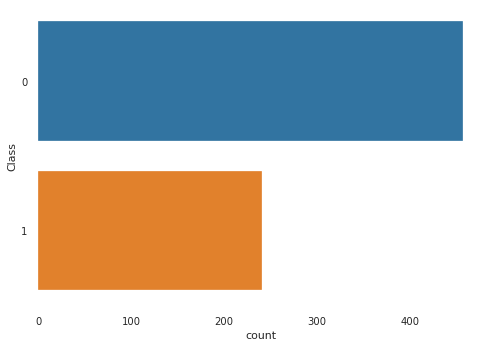

In [9]:
sns.countplot(y='Class', data=data)   
freq_tbl(data['Class'].astype('str'))

**¿Las variables tienen mucha variación? ¿cuales son sus percentiles?**

In [10]:
profiling_num(data)

variable          mean        std_dev  variation_coef  \
0           Sample code number  1.071807e+06  617532.274029        0.576160   
1              Clump Thickness  4.416905e+00       2.817673        0.637929   
2      Uniformity of Cell Size  3.137536e+00       3.052575        0.972921   
3     Uniformity of Cell Shape  3.210602e+00       2.972867        0.925953   
4            Marginal Adhesion  2.809456e+00       2.856606        1.016783   
5  Single Epithelial Cell Size  3.217765e+00       2.215408        0.688493   
6              Bland Chromatin  3.438395e+00       2.440056        0.709650   
7              Normal Nucleoli  2.869628e+00       3.055004        1.064600   
8                      Mitoses  1.590258e+00       1.716162        1.079172   
9                        Class  3.452722e-01       0.475798        1.378037   

      p_0.01    p_0.05     p_0.25      p_0.5     p_0.75     p_0.95      p_0.99  
0  145430.23  411453.0  870258.25  1171710.0  1238354.0  1333897.7  1368267.18  
1       1.00       1.0       2.00        4.0        6.0       10.0       10.00  
2       1.00       1.0       1.00        1.0        5.0       10.0       10.00  
3       1.00       1.0       1.00        1.0        5.0       10.0       10.00  
4       1.00       1.0       1.00        1.0        4.0       10.0       10.00  
5       1.00       1.0       2.00        2.0        4.0        8.0       10.00  
6       1.00       1.0       2.00        3.0        5.0        8.0       10.00  
7       1.00       1.0       1.00        1.0        4.0       10.0       10.00  
8       1.00       1.0       1.00        1.0        1.0        5.0       10.00  
9       0.00       0.0       0.00        0.0        1.0        1.0        1.00

![](https://lexia.cc/wp-content/uploads/2019/10/shutterstock_1171910626.jpg)

Fuente: https://lexia.cc/mes-de-la-prevencion-del-cancer-de-mama/?utm_source=LEXIA+Contactos&print=print

*******************

# Preparación de los datos

**Registros duplicados**

Son 54 en total<br>
Pero los voy a dejar, podría ser que la misma persona se haya hecho estudios otra vez, pero tendría distintos valores

In [11]:
data [data.duplicated(subset="Sample code number") ]

Sample code number  Clump Thickness  Uniformity of Cell Size  \
8               1033078                4                        2   
29              1070935                3                        1   
81              1143978                5                        2   
108             1171710                6                        5   
115             1173347                8                        3   
120             1174057                4                        2   
194             1212422                4                        1   
207             1218860                1                        1   
251             1017023                6                        3   
252             1100524                6                       10   
253             1116116                9                       10   
254             1168736                5                        6   
255             1182404                3                        1   
256             1182404                3                        1   
257             1198641                3                        1   
264             1182404                5                        1   
265             1198641               10                       10   
271              320675                3                        3   
321              733639                3                        1   
337              704097                1                        1   
371              493452                4                        1   
373              560680                3                        1   
387             1114570                2                        1   
392             1158247                1                        1   
428             1276091                2                        1   
429             1276091                1                        3   
430             1276091                5                        1   
433             1293439                6                        9   
442              734111                1                        1   
447             1182404                1                        1   
461             1276091                6                        1   
467             1105524                4                        1   
489             1115293                1                        1   
496             1182404                4                        2   
516             1320077                1                        1   
525              769612                4                        1   
526              798429                4                        1   
536             1116192                5                        1   
547             1240603                3                        1   
551             1299924                3                        2   
560             1321942                5                        1   
574              385103                5                        1   
606              411453                1                        1   
611              822829                8                       10   
617             1061990                4                        1   
631             1238777                1                        1   
638             1277792                5                        1   
643             1299596                2                        1   
660             1339781                4                        1   
672             1354840                5                        3   
683              466906                1                        1   
689              654546                1                        1   
690              695091                5                       10   
697              897471                4                        8   

     Uniformity of Cell Shape  Marginal Adhesion  Single Epithelial Cell Size  \
8                           1                  1                            2   
29                          1                  

Entonces, veamos si alguno de esos duplicados, tambien esta duplicado en las demas variables

In [12]:
freq_tbl(data.duplicated().astype('str'))

NaN  frequency  percentage  cumulative_perc
0  False        690    0.988539         0.988539
1   True          8    0.011461         1.000000

Efectivamente, hay 8 registros que estan completamente duplicados. Esos los vamos a eliminar

In [13]:
data.drop_duplicates(keep=False,inplace=True)

Eliminemos la variable ID Sample code number, ya que no la vamos a utilizar en el modelo

In [14]:
data = data.drop(['Sample code number'],axis=1)

**Veamos que sucede con la variable Bare Nuclei**

In [15]:
freq_tbl(data['Bare Nuclei'])

Bare Nuclei  frequency  percentage  cumulative_perc
0            1        391    0.573314         0.573314
1           10        128    0.187683         0.760997
2            2         30    0.043988         0.804985
3            5         30    0.043988         0.848974
4            3         28    0.041056         0.890029
5            8         19    0.027859         0.917889
6            4         19    0.027859         0.945748
7            ?         16    0.023460         0.969208
8            9          9    0.013196         0.982405
9            7          8    0.011730         0.994135
10           6          4    0.005865         1.000000

Hay 16 registros en donde la variable llega como '?'<br>
Probablemente se deba a que al momento de cargar los datos, se desconocia el valor.<br>
Un posible enfoque sería reemplazar esos '?' por la media (promedio) de todo el set de datos para esa variable.<br>

In [16]:
import numpy as np

Primero los pasamos a nulo

In [17]:
# Primero los pasamos a nulo
data['Bare Nuclei'] = data['Bare Nuclei'].replace({'?': np.nan})

Ahora convertimos el tipo de datos. A integer no permite por tener nulo, pero si me deja a float

In [18]:
# Ahora convertimos el tipo de datos. A integer no permite por tener nulo, pero si me deja a float
data['Bare Nuclei']=data['Bare Nuclei'].astype(float) 

Reemplazo los nulos por la media 

In [19]:
# Reemplazo los nulos por la media 
data['Bare Nuclei']=data['Bare Nuclei'].fillna(data['Bare Nuclei'].mean())

Finalmente convierto a int

In [20]:
# Finalmente convierto a int
data['Bare Nuclei']=data['Bare Nuclei'].astype(int)

In [21]:
# con esto se puede verificar si asigno correctamente la media en cada registro
#data.loc[[22,39,138,144,157,163,234,248,274,291,293,296,314,320,410,616],:]

<img src="https://www.geicam.org/wp-content/uploads/2016/03/signos-y-s%C3%ADntomas.jpg" width="500">

Fuente: https://www.geicam.org/cancer-de-mama/el-cancer-de-mama-se-puede-prevenir/sintomas-del-cancer-de-mama

********************

# Correlaciones
¿Cuales son las variables que más influyen a detectar si tiene cancer o no?<br>
Vamos a usar la función corr_pair de funpymodeling

In [22]:
cor_d=corr_pair(data)

In [23]:
cor_d_class = cor_d[cor_d['v1']=='Class']

In [24]:
cor_d_class.sort_values(by=['R2'],ascending=False)

v1                           v2         R        R2
19  Class      Uniformity of Cell Size  0.817403  0.668147
29  Class     Uniformity of Cell Shape  0.816281  0.666315
59  Class                  Bare Nuclei  0.812807  0.660656
69  Class              Bland Chromatin  0.756743  0.572660
79  Class              Normal Nucleoli  0.718751  0.516603
9   Class              Clump Thickness  0.718421  0.516129
39  Class            Marginal Adhesion  0.705869  0.498250
49  Class  Single Epithelial Cell Size  0.679478  0.461690
89  Class                      Mitoses  0.424917  0.180554

Vemos rápidamente las correlaciones.<br>
R2 indica si hay correlación. 0= no hay correlacion 1= mucha correlacion<br>
R tambien indica si hay correlación, y si es positiva o negativa. -1=negativa 0=no hay correlacion 1=positiva

Estas parecen ser las 5 variables que más ayudan a predecir la clase: (en este orden)
1. Uniformity of Cell Shape
1. Uniformity of Cell Size
1. Bare Nuclei
1. Bland Chromatin
1. Clump Thickness

¿Hay variables que tienen mucha correlación entre si? Esto indicaria que podemos prescindir de alguna<br>
Por ejemplo, sabiendo la fecha de nacimiento, podríamos saber la edad de una persona. Entonces la variable edad es prescindible<br>
Veamoslo con el estadístico Pearson

In [25]:
data.corr().sort_values(by=['Class'],ascending=False)

Clump Thickness  Uniformity of Cell Size  \
Class                               0.718421                 0.817403   
Uniformity of Cell Size             0.642202                 1.000000   
Uniformity of Cell Shape            0.653429                 0.903828   
Bare Nuclei                         0.590444                 0.683354   
Bland Chromatin                     0.563873                 0.763562   
Normal Nucleoli                     0.535929                 0.731621   
Clump Thickness                     1.000000                 0.642202   
Marginal Adhesion                   0.489907                 0.720726   
Single Epithelial Cell Size         0.513256                 0.742089   
Mitoses                             0.350818                 0.461356   

                             Uniformity of Cell Shape  Marginal Adhesion  \
Class                                        0.816281           0.705869   
Uniformity of Cell Size                      0.903828           0.720726   
Uniformity of Cell Shape                     1.000000           0.698987   
Bare Nuclei                                  0.703343           0.677446   
Bland Chromatin                              0.741183           0.673042   
Normal Nucleoli                              0.729986           0.601291   
Clump Thickness                              0.653429           0.489907   
Marginal Adhesion                            0.698987           1.000000   
Single Epithelial Cell Size                  0.708722           0.617544   
Mitoses                                      0.442202           0.416526   

                             Single Epithelial Cell Size  Bare Nuclei  \
Class                                           0.679478     0.812807   
Uniformity of Cell Size                         0.742089     0.683354   
Uniformity of Cell Shape                        0.708722     0.703343   
Bare Nuclei                                     0.575909     1.000000   
Bland Chromatin                                 0.625137     0.673202   
Normal Nucleoli                                 0.639324     0.584450   
Clump Thickness                                 0.513256     0.590444   
Marginal Adhesion                               0.617544     0.677446   
Single Epithelial Cell Size                     1.000000     0.575909   
Mitoses                                         0.486234     0.340834   

                             Bland Chromatin  Normal Nucleoli   Mitoses  \
Class                               0.756743         0.718751  0.424917   
Uniformity of Cell Size             0.763562         0.731621  0.461356   
Uniformity of Cell Shape            0.741183         0.729986  0.442202   
Bare Nuclei                         0.673202         0.584450  0.340834   
Bland Chromatin                     1.000000         0.672353  0.343426   
Normal Nucleoli                     0.672353         1.000000  0.426781   
Clump Thickness                     0.563873         0.535929  0.350818   
Marginal Adhesion                   0.673042         0.601291  0.416526   
Single Epithelial Cell Size         0.625137         0.639324  0.486234   
Mitoses                             0.343426         0.426781  1.000000   

                                Class  
Class                        1.000000  
Uniformity of Cell Size      0.817403  
Uniformity of Cell Shape     0.816281  
Bare Nuclei                  0.812807  
Bland Chromatin              0.756743  
Normal Nucleoli              0.718751  
Clump Thickness              0.718421  
Marginal Adhesion            0.705869  
Single Epithelial Cell Size  0.679478  
Mitoses                      0.424917

Parece que hay correlacion entre Uniformity of Cell Shape y Uniformity of Cell Size (0.906814). <br>
Es decir, sabiendo una, es posible predecir la otra.<br>
Si consideramos 0.90 como mínimo para decir que esta altamente correlacionada, esas dos serían las unicas (algunas dan 1 porque se comparan con si mismas).
Nota: si bien vemos que estan muy correlacionadas, en este caso dejamos ambas variables ya que tenemos pocas en nuestro set de datos.

Veamoslo graficamente

Cuanto más azul el cuadro, menos relacion hay.
En contraste, en los focos rojos es donde se encuentran las correlaciones.

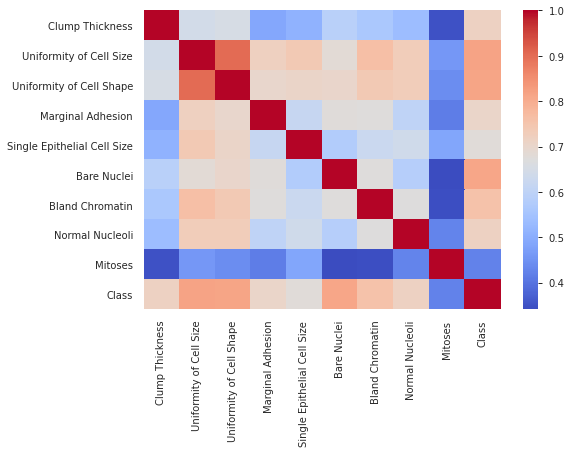

In [26]:
sns.heatmap(data.corr(), cmap='coolwarm')

# ¿Como influye cada variable importante sobre la variable a predecir?

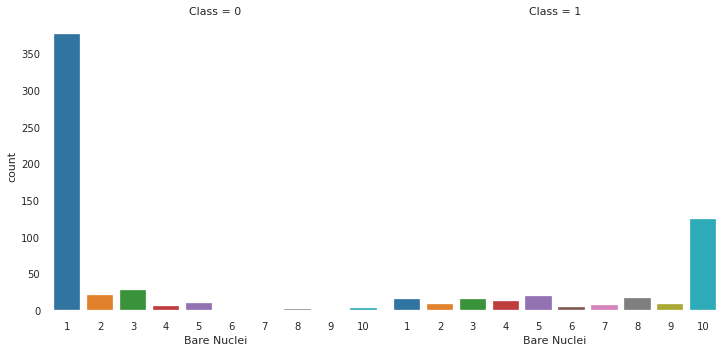

In [27]:
g = sns.catplot(x="Bare Nuclei",
                col="Class",
                data= data,
                kind="count")

En casos que no hay cáncer, la mayoria tiene un Bare Nuclei de 1.<br>
Sin embargo, en los que si hay cáncer, vemos que muchos tienen un Bare Nuclei de 10<br>
Es decir, si el Bare nuclei es de 10, es probable que la persona tenga cancer.<br>

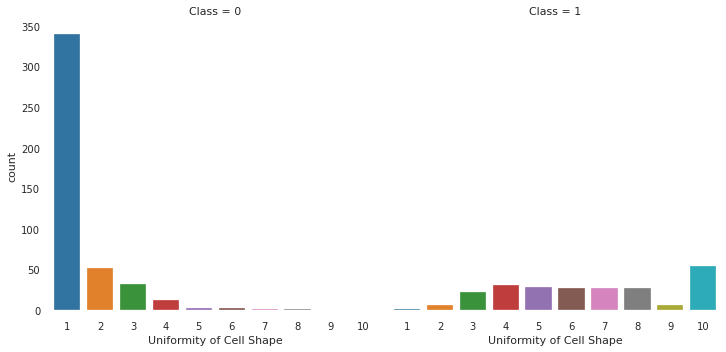

In [28]:
g = sns.catplot(x="Uniformity of Cell Shape",
                col="Class",
                data= data,
                kind="count")

En los tumores benignos, la mayoria tiene un Uniformity of Cell Shape de 1.<br>
Sin embargo los malignos, vemos que tienen un Uniformity of Cell Shape de 10<br>
Es decir, si el Uniformity of Cell Shape es de 10, es probable que la persona tenga cancer.<br>

# **Valores extremos**

Esto es importante, ya que si existen outliers (valores extremos donde por ejemplo muy pocos casos presenten un valor alto, y la mayoria presenten un valor bajo) pueden llegar a perjudicar la capacidad de predicción del modelo que creemos

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9513d37350>,
      dtype=object)

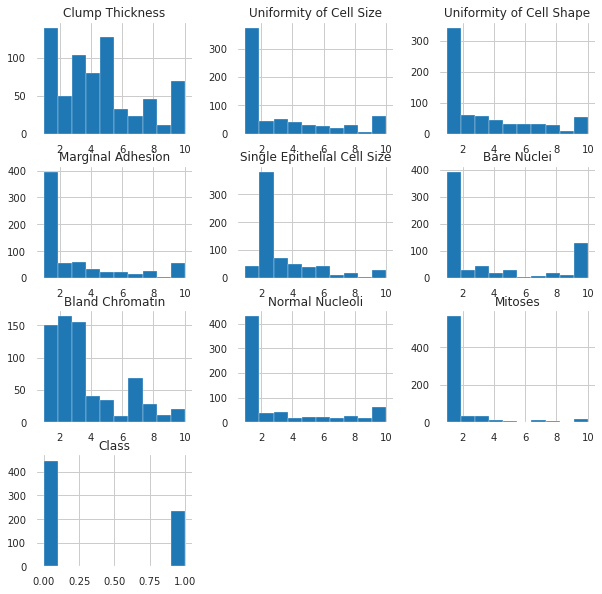

In [29]:
data.hist(figsize = (10,10))

No veo nada significativo. Por ahora no tocamos nada

<img src="https://i.pinimg.com/originals/00/8d/43/008d43e2ad03e14988628c5ac2b10851.jpg" width="500">

*************************

# Modelo de predicción

Vamos a usar un modelo de regresión logística. <br>
Este modelo nos va a predecir, por cada registro, la probabilidad de que la persona tenga cáncer<br>
1. Primero que todo separamos nuestras variables de entrada, de nuestras variables de salida
1. Luego escalamos los datos de entrada (este es requisito del modelo)
1. Una vez tenemos nuestros datos de entrada ya escalados, separamos nuestros datos. <br>
Por un lado vamos a tener los datos de training (80% de los datos) y por el otro, datos de testing (20%). <br>
1. Entrenamos nuestro modelo con los datos de training, y luego eso se prueba con los datos de test

In [30]:
# 1. Separamos nuestras variables de entrada, de nuestras variables de salida
data_x=data.drop('Class', axis=1)
data_y=data['Class']

In [31]:
# 2. Escalamos los datos de entrada
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(data_x)

In [32]:
# 3. separamos nuestros datos
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_scaled, data_y, test_size=0.2)

Entrenamos nuestro modelo con los datos de training<br>
Basicamente le decimos al modelo que con las variables de entrada 'x', la salida es 'y'

In [33]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(x_train,y_train)

LogisticRegression()

¿Qué devuelve el modelo? Devuelve la probabilidad de que sí tenga cáncer. <br>
Sería la segunda columna del siguiente array:

In [34]:
model.predict_proba(x_test)

array([[1.79175578e-02, 9.82082442e-01],
       [1.87392505e-05, 9.99981261e-01],
       [9.85052592e-01, 1.49474076e-02],
       [9.95891242e-01, 4.10875830e-03],
       [9.97725894e-01, 2.27410644e-03],
       [9.74046895e-01, 2.59531048e-02],
       [9.75342257e-01, 2.46577433e-02],
       [1.62718559e-02, 9.83728144e-01],
       [8.56443334e-04, 9.99143557e-01],
       [9.93416501e-01, 6.58349908e-03],
       [9.87865643e-01, 1.21343567e-02],
       [9.82129441e-01, 1.78705592e-02],
       [9.85052592e-01, 1.49474076e-02],
       [5.14702009e-06, 9.99994853e-01],
       [5.50550849e-06, 9.99994494e-01],
       [1.07942748e-01, 8.92057252e-01],
       [7.24039660e-07, 9.99999276e-01],
       [9.95819132e-01, 4.18086800e-03],
       [9.86713061e-01, 1.32869386e-02],
       [9.95891242e-01, 4.10875830e-03],
       [9.86713061e-01, 1.32869386e-02],
       [1.76312072e-02, 9.82368793e-01],
       [9.97088949e-01, 2.91105126e-03],
       [7.26297892e-04, 9.99273702e-01],
       [8.937078

Veamos la matriz de confusión para training, con un **punto de corte de 0.5**<br>
Un punto de corte de 0.5 quiere decir que si la probabilidad de que tenga cáncer es mayor a 50% el modelo le asigna que SI tiene cáncer. <br>
En cambio, si es menor a 50% el modelo declara que NO tiene cáncer

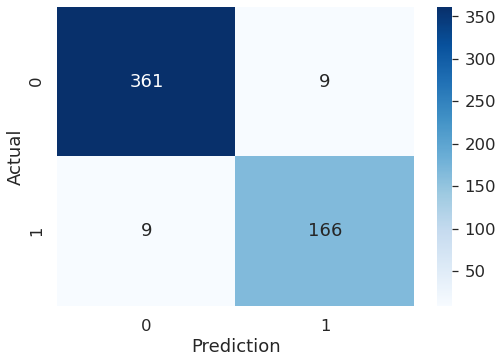

In [35]:
y_pred50=model.predict(x_train)

sns.set(font_scale=1.5) #  Ajuste tamaño de letra (var global)
conf_mat1=pd.crosstab(index=y_train, # filas = valor real
                     columns=y_pred50, # columnas = valor predicho
                     rownames=['Actual'], 
                     colnames=['Prediction']
                     )

import seaborn as sns
sns.heatmap(conf_mat1, annot=True, cmap='Blues', fmt='g')

No está mal. Pero pensemos que quiere decir esta matriz de confusión. <br>
Recordemos que 0 = NO TIENE CANCER  /  1= SI TIENE CANCER<br>

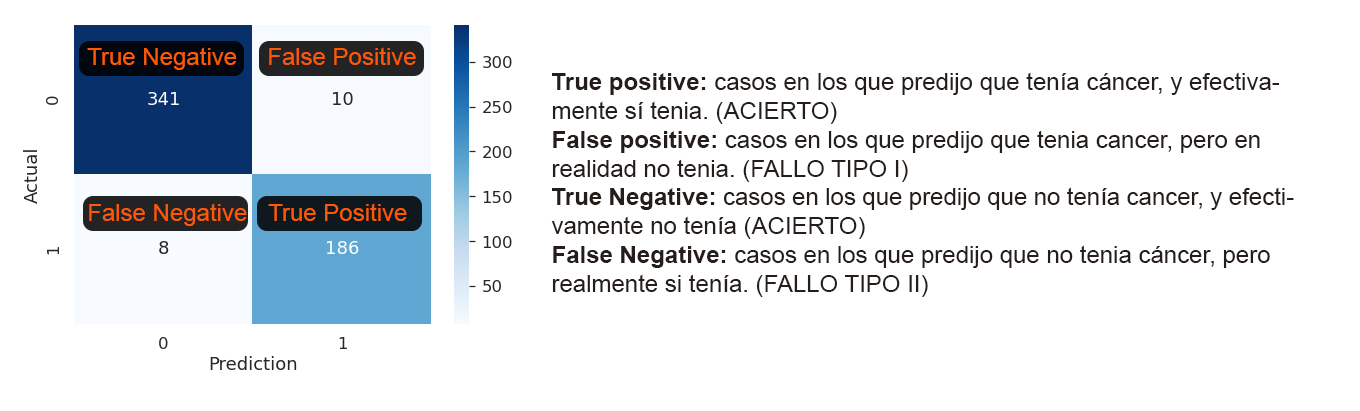

Nota: estos valores pueden variar un poco de lo que indican aca abajo. Esto sucede porque las muestras que tomamos para entrenar al modelo son aleatorias.<br>
Detectó 183 personas con cáncer... y SI tenian! (llamado True positive) Esa es una predicción muy buena.<br>
Pero atencion, hubo 9 casos en donde predijo cáncer, y NO habia (a estos casos se los denomina False positive)<br>
De los que el modelo dijo que NO TIENE CANCER, efectivamente 345 NO TENIAN (llamados True negative)<br>
Pero, tambien hubo 8 personas a quienes NO les detecto cáncer y SI TENIAN (llamados False negative).

**De estos 2 casos de fallos, el peor es el de tipo II (false negative)<br>
Imaginense, es feo que a una persona le predigan cáncer y en verdad no lo tenga (fallo tipo I)..pero en definitiva con los estudios correspondientes lo va a saber.
En cambio, imaginense que una persona tiene cáncer, y el modelo no lo prediga...**

# **Accuracy o exactitud del modelo<br>**
Es una métrica que indica que tan bueno es acertando

In [36]:
confusion_matrix = confusion_matrix(y_train, y_pred50)

true_negative = confusion_matrix[0][0]
false_positive = confusion_matrix[0][1]
false_negative = confusion_matrix[1][0]
true_positive = confusion_matrix[1][1]

In [37]:
Accuracy = (true_negative + true_positive)/ (true_negative + true_positive + false_negative + false_positive)
Accuracy

0.9669724770642202

Bien, tenemos un accuracy muy bueno.

# Testing

Veamos la misma matriz pero con datos de testing (estos son los datos que el modelo desconoce)

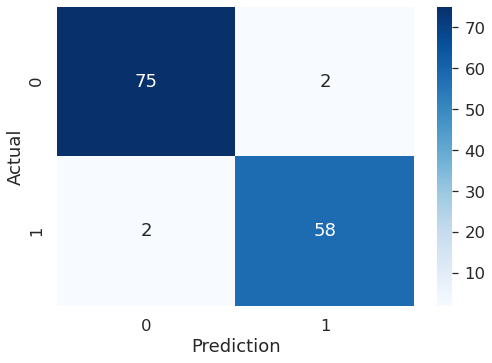

In [38]:
y_pred50Test=model.predict(x_test)

sns.set(font_scale=1.5) #  Ajuste tamaño de letra (var global)
conf_mat1=pd.crosstab(index=y_test, # filas = valor real
                     columns=y_pred50Test, # columnas = valor predicho
                     rownames=['Actual'], 
                     colnames=['Prediction']
                     )

import seaborn as sns
sns.heatmap(conf_mat1, annot=True, cmap='Blues', fmt='g')

Tambien responde muy bien con datos que no conoce

# Grafiquemos la curva ROC<br>

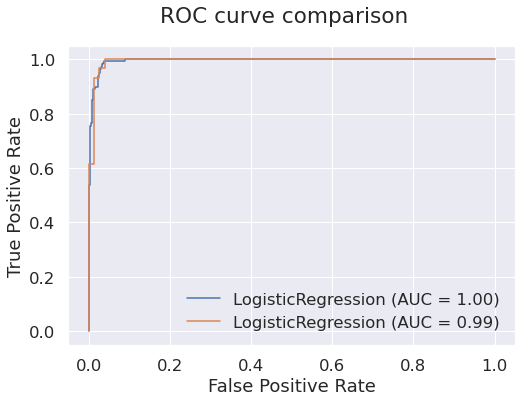

In [39]:
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt

svc_disp = plot_roc_curve(model, x_train, y_train)
rfc_disp = plot_roc_curve(model, x_test, y_test, ax=svc_disp.ax_)
rfc_disp.figure_.suptitle("ROC curve comparison")
plt.show()

# ¿Qué pasa si variamos el punto de corte?

Ahora, dijimos que por defecto el punto de corte en la matriz es de 0.5<br>
Al ser predicciones tan importantes, tal vez nos convenga intentar reducir los errores de "False Negative".<br>
Esto lo podriamos lograr cambiando el punto de corte a uno menor. Veamos un ejemplo para que se entienda:<br>
Punto de corte en 0.5: Si en un caso x, la predicción de que si tenga cáncer es de 0.45, el modelo lo clasifica como que NO TIENE CANCER<br>
En cambio, punto de corte en 0.4= Mismo caso x, predicción nos da 0.45, pero ahora el modelo lo clasificó como que SI TIENE CANCER <br>
Entonces..al ir bajando el punto de corte reducimos las predicciones negativas incorrectas, pero tambien, aumentamos las predicciones positivas incorrectas<br>
Se trata de ir encontrando un equilibrio dependiendo de la necesidad. En este caso, como dijimos antes, es muy importante predecir bien a quienes si tienen cancer, por eso vamos a probar con un punto de corte menor

Probemos con un **punto de corte de 0.3**

In [40]:
y_pred_tr = model.predict_proba(x_train)

Ahora centremonos en los datos de training. <br>
Y analicemos solamente la segunda columna. Es decir, nos quedamos con la columna que indica la probabilidad de que SI tenga cancer.

In [41]:
#aqui solo tomo la segunda columna de la predicción de training
y_prob_tr=y_pred_tr[:,1]

In [42]:
y_pred30=np.where(y_prob_tr > 0.3, 1, 0)

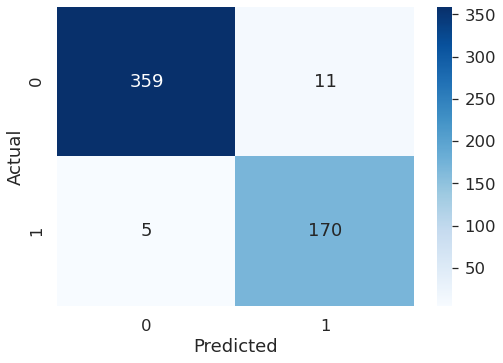

In [43]:
conf_mat30=pd.crosstab(index=y_train, 
                      columns=y_pred30, 
                      rownames=['Actual'], 
                      colnames=['Predicted']
                      )

import seaborn as sns
sns.heatmap(conf_mat30, annot=True, cmap='Blues', fmt='g')



Redujimos los false negative. Es decir el modelo va a detectar correctamente más casos de SI TIENE CANCER.
Esto se logra moviendo el punto de corte, entonces al reducir los false negative, aumentamos los false positive.
El punto de corte más adecuado va a estar definido por la necesidad puntual, en este caso prefiero seguir reduciendo los false negative por lo que comenté antes.


Veamos el accuracy para el **punto de corte de 0.3**

In [44]:
from sklearn.metrics import confusion_matrix
confusion_matrix30 = confusion_matrix(y_train, y_pred30)

In [45]:
true_negative30 = confusion_matrix30[0][0]
false_positive30 = confusion_matrix30[0][1]
false_negative30 = confusion_matrix30[1][0]
true_positive30 = confusion_matrix30[1][1]

In [46]:
Accuracy30 = (true_negative30 + true_positive30)/ (true_negative30 + true_positive30 + false_negative30 + false_positive30)
Accuracy30

0.9706422018348624

Y hasta aqui llega mi analisis, los modelos seguramente se puedan mejorar. En cuanto disponga de tiempo libre, voy a continuarlo :D

# Links de utilidad

Y como nunca esta de más, dejo algunos links en español con información sobre el cancer de mama.


Descripción, prevención y sintomas:
https://www.mayoclinic.org/es-es/diseases-conditions/breast-cancer/symptoms-causes/syc-20352470

Descripción, prevención y sintomas (Ministerio de salud Argentina):
http://msal.gob.ar/index.php/component/content/article/46-ministerio/199-2-prevencion-de-cancer-de-mama-#:~:text=El%20c%C3%A1ncer%20de%20mama%20en%20cifras%20en%20Argentina&text=El%20c%C3%A1ncer%20de%20mama%20es%20la%20primera%20causa%20de%20muerte,provocando%205400%20muertes%20por%20a%C3%B1o.&text=En%20el%20pa%C3%ADs%20se%20presenta,de%20mortalidad%20entre%20diferentes%20provincias.

Programa nacional de control del cancer de mama (Argentina):
https://www.argentina.gob.ar/salud/instituto-nacional-del-cancer/institucional/pncm

**Consultar periodicamente a profesionales medicos es la mejor manera de prevenirlo.**